In [11]:
# import statements

import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [9]:
wof = xr.open_dataset('/mnt/drive2/wof-runs/wrfout_d01_2021-09-01_20:00:00')
region = [wof.XLONG.min(),wof.XLONG.max(),wof.XLAT.min(),wof.XLAT.max()]

/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


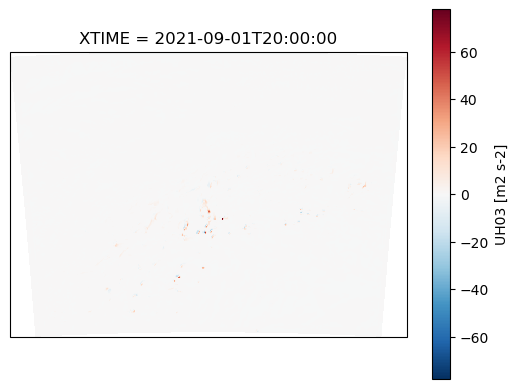

In [21]:
p = wof.UH03.isel(Time=0).plot(x="XLONG",y="XLAT",
                               subplot_kws=dict(projection=ccrs.LambertConformal(),
                                                transform=ccrs.PlateCarree()))
# p.axes.set_extent(region)
# p.axes.add_feature(cfeature.STATES)
# p.axes.coastlines()